In [1]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from datasets import load_dataset

# ------------------------
# CONFIG
# ------------------------
MODEL_NAME = "t5-small-separated20000"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
FP_RADIUS = 2
FP_BITS = 2048
NUM_CORES = 8
MAX_LENGTH = 256



In [2]:
# ------------------------
# LOAD MODEL / TOKENIZER
# ------------------------
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.to(DEVICE)
model.eval()

# ------------------------
# LOAD HUGGINGFACE DATASET
# ------------------------
# Example: dataset with 'input' and 'target' columns
dataset = load_dataset("Thecoder3281f/MIT_separated_final", "normal", split="test")  
# dataset = load_dataset("csv", data_files="test.csv")["train"]  # alternative

# Extract columns
test_inputs = dataset["input"]   # reactant SMILES
test_refs   = dataset["target"]  # product SMILES



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
from tqdm import tqdm

In [4]:
# ------------------------
# 1. Canonicalize SMILES
# ------------------------
def canon(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return ""
    return Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True)

test_refs_c = [canon(s) for s in test_refs]





In [13]:
BATCH_SIZE=64

In [14]:



# ------------------------
# 2. Batched prediction with progress bar
# ------------------------
def batch_generate(inputs, batch_size=BATCH_SIZE, max_length=MAX_LENGTH):
    preds = []
    for i in tqdm(range(0, len(inputs), batch_size), desc="Generating batches"):
        batch = inputs[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        with torch.no_grad():
            outs = model.generate(**enc, max_length=max_length)
        batch_preds = [tokenizer.decode(o, skip_special_tokens=True) for o in outs]
        preds.extend(batch_preds)
    return preds

preds_raw = batch_generate(test_inputs)
preds_c = [canon(s) for s in preds_raw]

Generating batches: 100%|██████████| 625/625 [16:19<00:00,  1.57s/it]
[22:37:48] Can't kekulize mol.  Unkekulized atoms: 16 17 18 28 31
[22:37:48] SMILES Parse Error: unclosed ring for input: 'C=C(C)C(=O)Oc1ccc(N2C(=O)C(=C(C)c3cc(-c4ccccc4)sc3C)C(=O)C2=C(C)C2=O)cc1'
[22:37:48] SMILES Parse Error: extra open parentheses while parsing: CC(C)Cc1ccc(COc2ccc3c(c2)n(CC2CC(C(=O)OC(C)(C)C)C(F)(F)F)c2cc1
[22:37:48] SMILES Parse Error: check for mistakes around position 12:
[22:37:48] CC(C)Cc1ccc(COc2ccc3c(c2)n(CC2CC(C(=O)OC(
[22:37:48] ~~~~~~~~~~~^
[22:37:48] SMILES Parse Error: Failed parsing SMILES 'CC(C)Cc1ccc(COc2ccc3c(c2)n(CC2CC(C(=O)OC(C)(C)C)C(F)(F)F)c2cc1' for input: 'CC(C)Cc1ccc(COc2ccc3c(c2)n(CC2CC(C(=O)OC(C)(C)C)C(F)(F)F)c2cc1'
[22:37:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[22:37:48] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(S(=O)(=O)OCC(Oc2cccn3nccc23)CO2)cc1'
[22:37:48] Can't kekulize mol.  Unkekulized atoms: 2 6 7 8 9 10 11 12 14 16 20
[22:37:48] 

In [15]:
preds_c[0]

'N#Cc1ccsc1Nc1cc([N+](=O)[O-])c(F)cc1F'

In [22]:
# ------------------------
# 3. Parallel Morgan fingerprint computation
# ------------------------
def mol_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    print(mol)
    if mol is None:
        return np.zeros(FP_BITS, dtype=np.int8)
    arr = AllChem.GetMorganFingerprintAsBitVect(mol, FP_RADIUS)
    return arr

fps_preds = Parallel(n_jobs=NUM_CORES)(delayed(mol_to_fp)(s) for s in preds_c)
fps_refs  = Parallel(n_jobs=NUM_CORES)(delayed(mol_to_fp)(s) for s in test_refs_c)

fps_preds = np.array(fps_preds)
fps_refs  = np.array(fps_refs)



In [29]:
# ------------------------
# 4. Batch Tanimoto similarity
# ------------------------
def tanimoto_batch(fps_pred, fps_ref):
    intersection = np.bitwise_and(fps_pred, fps_ref).sum(axis=1)
    union = np.bitwise_or(fps_pred, fps_ref).sum(axis=1)
    sims = np.where(union == 0, 0.0, intersection / union)
    return sims

sims = tanimoto_batch(fps_preds, fps_refs)




In [30]:
sims

array([0.75555556, 0.        , 0.26582278, ..., 0.41269841, 1.        ,
       1.        ])

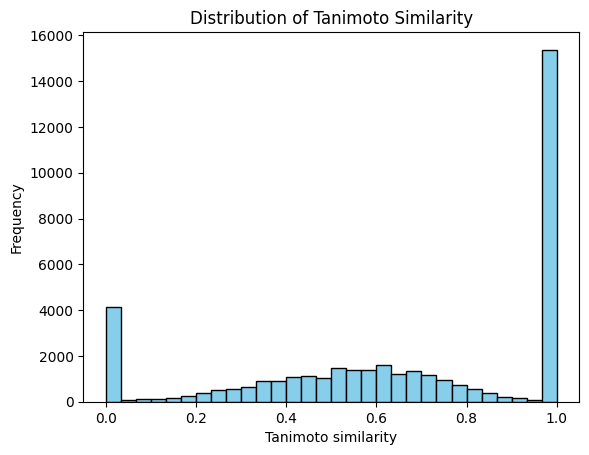

In [31]:
# ------------------------
# 5. Plot histogram
# ------------------------
plt.hist(sims, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Tanimoto similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Tanimoto Similarity")
plt.show()



In [33]:
# ------------------------
# 6. Optional: threshold counts
# ------------------------
for t in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f"Tanimoto > {t}: {np.mean(sims > t):.3f}")

Tanimoto > 0.3: 0.841
Tanimoto > 0.4: 0.778
Tanimoto > 0.5: 0.691
Tanimoto > 0.6: 0.590
Tanimoto > 0.7: 0.489
Tanimoto > 0.8: 0.417
Tanimoto > 0.9: 0.390
